In [2]:
import numpy as np
import scipy
from numba import njit, vectorize, int32, int64, float32, float64
import csv
with open("in2.txt", "r") as datafile:
    readfile = csv.reader(datafile)
    data = []
    for row in readfile:
        str_row = row[0].split()
        int_row = []
        for i in str_row:
            int_row.append(float(i))
        data.append(int_row)
   
    N = int(data[0][0])
    t_max = data[0][1]
    t_delta = data[0][2]/100
    m= np.array(data[1:N+1])
    r = np.array(data[N+1:2*N+1])
    v = np.array(data[2*N+1:])

# Schwerpunktransformation
m = m/sum(m)
R = sum(m*r)
RV = sum(m*v)
r_transformed = r-R
v_transformed = v-RV
delta_t = t_delta



In [3]:
# physical functions

# Beschleunigung
@njit
def acc_vec(pos):
    a = np.zeros((N,3))
    for i in range(N):
        store = np.zeros((N,3))
        for j in range(N):
            if i!=j:
                store[j,:] = (m[j,0]*(pos[j,:]-pos[i,:])/np.sum((pos[j,:]-pos[i,:])**2,axis=0)**(3/2))
        a[i,:] =np.sum(store,axis=0)
    return a

  
@njit
def dot(a,b):
    for i in range(3):
        return (a[0]*b[0]+a[1]*b[1]+a[2]*b[2])

# ableitung der Beschleunigung
@njit 
def acc_der(pos,vel):
    a = np.zeros((N,3))
    for i in range(0,N):
        store = np.zeros((N,3))
        for j in range(0,N):
            if i!=j:
                store[j,:] = (m[j,0]*((vel[j,:]-vel[i,:])/(np.sum((pos[j,:]-pos[i,:])**2)**(3/2))-3*np.sum((vel[j,:]-vel[i,:])*(pos[j,:]-pos[i,:]))*(pos[j,:]-pos[i,:])/(np.sum((pos[j,:]-pos[i,:])**2)**(5/2))))
        a[i,:] = np.sum(store,axis=0)
    return a 

# Energie
@njit
def eng(pos,vel,k):
    v_sq= np.sum(vel*vel,axis=1)
    T= np.sum(m[:,0]*v_sq)/2
    V= np.zeros(N)
    for n in range(N):
        
        norm = np.sqrt(np.sum((pos-pos[n])**2,axis=1))
        norm[n]=1
        V[n]= np.sum(m[:,0]*m[n,0]*1/norm,axis=0)/2-m[n,0]*m[n,0]/2

    V = np.sum(V)
    return T-V

# Gesamtdrehimpuls
@njit
def total_angular_momentum(pos,vel):
    cross = np.zeros((N,3))
    for n in range(N):
        cross[n,0] = pos[n,1]*vel[n,2]-pos[n,2]*vel[n,1]
        cross[n,1] = pos[n,2]*vel[n,0]-pos[n,0]*vel[n,2]
        cross[n,2] = pos[n,0]*vel[n,1]-pos[n,1]*vel[n,0]
        cross[n,:] *= m[n,0]
    return np.sum(cross,axis=0)

# Gesamtimpuls
@njit
def total_momentum(vel):
    mom = np.zeros((N,3))
    for n in range(N):
        mom[n,:] = m[n,0]*vel[n,:]
    return np.sum(mom,axis=0)

# Kreuzprodukt
@njit 
def cross(a,b):
    c = np.zeros(3)
    c[0] = a[1]*b[2]-a[2]*b[1]
    c[1] = a[2]*b[0]-a[0]*b[2]
    c[2] = a[0]*b[1]-a[1]*b[0]
    return c

# spezifischer Drehimpuls
@njit
def j_vec(pos,vel):
    r = pos[1,:]-pos[0,:]
    v = vel[1,:]-vel[0,:]
    return cross(r,v), r, v

@njit
def runge_lenz(j,r,v):
    return cross(v,j)-r/np.sqrt(np.sum(r**2))

# Große Halbachse
@njit
def a_gha(j,e):
  return np.sum(j**2)/(1-np.sum(e**2))

# Fakultät
@njit
def fac(i):
    result = 1
    for x in range(2,i+1):
        result = result*x
    return result



In [26]:
# integrators, manche Funktionen haben ein rij_betrag, als Argument und Ausgabe, das nicht nötig ist. Habe ich gemacht um die iteratoren einheitlicher
# schreiben zu können, und am Ende wollte ich es dann nicht mehr umschreiben.
zero = np.zeros((N,3))

@njit
def euler(pos,vel,tdelt):
    a = acc_vec(pos)
    dta = acc_der(pos,vel)
    vel1 = vel+a*tdelt
    pos = pos+vel*tdelt
    return pos, vel1, a, dta
@njit  
def euler_cromer(pos,vel,tdelt):
    a = acc_vec(pos)
    dta = acc_der(pos,vel)
    vel2= vel+a*tdelt
    pos2 = pos+ vel2*tdelt
    return pos2, vel2, a, dta

@njit
def velo_verlet(pos,vel,a1,tdelt):
    
    pos = pos + vel*tdelt+a1*tdelt**2/2
    a2  = acc_vec(pos)
    vel = vel +(a1+a2)*tdelt/2
    return pos, vel, a2 
 
@njit
def kick_drift(pos,vel,a1,tdelt):
    dta = acc_der(pos,vel)
    vel1 = vel+a1*tdelt/2
    pos = pos +vel1*tdelt
    a2  = acc_vec(pos)
    vel = vel1 + a2*tdelt/2
    return pos, vel, a2, dta 
 
@njit
def predictor(pos,vel,a, dta,tdelt):
    vp= vel+a*tdelt+dta*tdelt*tdelt/2
    rp = pos+vel*tdelt+a*tdelt**2/2+dta*tdelt**3/6
    ap   = acc_vec(rp)
    dtap = acc_der(rp,vp)
    return rp, vp, ap, dtap

 
 

@njit
def hermite(pos,vel,tdelt):
    a  = acc_vec(pos)
    dta = acc_der(pos,vel)
    rp, vp, ap, dtap = predictor(pos,vel,a, dta,tdelt)
    # vp= vel+a*tdelt+dta*tdelt*tdelt/2
    # rp = pos+vel*tdelt+a*tdelt**2/2+dta*tdelt**3/6
    # ap   = acc_vec(rp)
    # dtap = acc_der(rp,vp)
    dt2a = -6*(a-ap)/tdelt**2-2*(2*dta+dtap)/tdelt
    dt3a = 12*(a-ap)/tdelt**3+6*(dta+dtap)/tdelt**2
    rc = rp+1/24*dt2a*tdelt**4+1/120*dt3a*tdelt**5
    vc = vp+1/6*dt2a*tdelt**3+1/24*dt3a*tdelt**4
    return rc, vc, a, dta, dt2a, dt3a 

@njit
def iterated_hermite(pos,vel,a, dta,tdelt):
    rp, vp, ap, dtap = predictor(pos,vel,a, dta,tdelt)
    dt2a = -6*(a-ap)/tdelt**2-2*(2*dta+dtap)/tdelt
    dt3a = 12*(a-ap)/tdelt**3+6*(dta+dtap)/tdelt**2
    it = 2
    for i in range(it+1):
        vc = vel + 1/2*(ap+a)*tdelt+1/12*(dtap-dta)*tdelt**2
        rc = pos + 1/2*(vc+vel)*tdelt+1/12*(ap-a)*tdelt**2
        rp, vp, ap, dtap = predictor(rc,vc,acc_vec(rc), acc_der(rc,vc),tdelt)
    return rc, vc, acc_vec(rc), acc_der(rc,vc), dt2a, dt3a




@njit
def hermite_integrator(pos,vel,a,ap,dta,dtap,tdelt):
    vc = vel + (a+ap)*delta_t/2+(dtap-dta)*delta_t**2/12
    rc = pos + (vc+vel)*delta_t/2+(ap-a)*delta_t**2/12
    ac   = acc_vec(rc)
    dtac = acc_der(rc,vc)
    rp, vp, ap, dtap = predictor(rc,vc,ac,dtac,tdelt)
    return rc, vc, ap, dtap, ac, dtac
 
# @njit
# def iterated_hermite(pos,vel,a, dta,tdelt):
#     # vp= vel+a*tdelt+dta*tdelt*tdelt/2
#     # rp = pos+vel*tdelt+a*tdelt**2/2+dta*tdelt**3/6
#     # a = np.zeros((3,N,3))
#     # dta = np.zeros((3,N,3))
#     # ap   = acc_vec(rp)
#     # dtap = acc_der(rp,vp)
#     rp, vp, ap, dtap = predictor(pos,vel,a,dta,tdelt)
#     it = 2
#     rc = np.zeros((it+2,N,3))
#     vc = np.zeros((it+2,N,3))
#     rc[0,:] = pos
#     vc[0,:] = vel
#     dt2a = -6*(a-ap)/tdelt**2-2*(2*dta+dtap)/tdelt
#     dt3a = 12*(a-ap)/tdelt**3+6*(dta+dtap)/tdelt**2
#     for i  in range(0,it+1):
#         rc[i+1,:], vc[i+1,:], ap, dtap, ac, dtac = hermite_integrator(pos,vel,a,ap,dta,dtap,tdelt)
#     a  = acc_vec(rc[-1,:])
#     dta = acc_der(rc[-1,:],vc[-1,:])
#     return rc[-1,:], vc[-1,:], a, dta, dt2a, dt3a

@njit 
def heun(pos,vel,tdelt):
    a  = acc_vec(pos)
    dta = acc_der(pos,vel)
    v1 = a*tdelt
    r1 = vel*tdelt
    v2 = acc_vec(pos+r1)[0]*tdelt
    r2 = (vel+v2)*tdelt
    v_iter=vel+(v1+v2)/2
    r_iter = pos +(r1+r2)/2
    return r_iter,v_iter,a, dta 
 
@njit
def rk4(pos,vel,tdelt):
    a  = acc_vec(pos)
    dta = acc_der(pos,vel)
    v1 = a*tdelt
    r1= vel*tdelt
    v2  = acc_vec(pos+r1/2)[0]*tdelt
    r2 = (vel+v1/2)*tdelt
    v3 = acc_vec(pos+r2/2)[0]*tdelt
    r3 = (vel+v2/2)*tdelt
    v4 = acc_vec(pos+r3)[0]*tdelt
    r4 = (vel+v3)*tdelt
    r_iter = pos +(r1+r4)/6+(r2+r3)/3
    v_iter = vel + (v1+v4)/6+(v2+v3)/3
    return r_iter, v_iter, a, dta 
 
 
# absolute values of a vector
@njit
def absol(x):
    return np.sqrt(np.sum(x*x,axis=1))

@njit 
def time_delta(a_iter,dta_iter):
    dta_abs = absol(dta_iter)
    for i in range(N):
        if dta_abs[i]==0:
            dta_abs[i]=0.0001    
    return min(absol(a_iter)/dta_abs)
 
@njit 
def time_delta_hermite(a,dta,dt2a,dt3a):
   return min((absol(a)*absol(dt2a)+absol(dta)**2)/(absol(dta)*absol(dt3a)+absol(dt2a)**2))**(1/2)*t_delta


In [27]:
@njit
def iterator(integrator_abrv,steps,block_size):
    if (N!=0):

        t_sum = 0
        delta_t=t_delta
        r_iter= r_transformed
        v_iter= v_transformed
        course_r = np.zeros((steps//block_size+1,N,3))
        course_v = np.zeros((steps//block_size+1,N,3))
        course_t = np.zeros((steps//block_size+1))
        course_r[0,:,:]=r_iter
        course_v[0,:,:]=v_iter
        course_t[0]= 0
       
        a_iter  = acc_vec(r_iter)
        
        dta_iter = acc_der(r_iter,v_iter)

        if (integrator_abrv=='hermite'):
            integrator = hermite
            
            for zähler in range(steps):
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter,v_iter,a_iter,dta_iter,dt2a,dt3a  = integrator(r_iter,v_iter,delta_t)
                delta_t = time_delta_hermite(a_iter,dta_iter,dt2a,dt3a)
                if (delta_t<abs(t_delta-0.3*t_delta)):
                    delta_t=abs(t_delta-0.3*t_delta)
                elif (t_delta+t_delta<delta_t):
                    delta_t=t_delta+t_delta
                if zähler%block_size==0:
                    
                    
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                # Zwischenstandausgabe
                if zähler%100000 == 0:
                    print(zähler)

        elif integrator_abrv=='iterated_hermite':
            integrator = iterated_hermite
          
            for zähler in range(1,steps):
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter,v_iter,a_iter,dta_iter,dt2a,dt3a = integrator(r_iter,v_iter,a_iter,dta_iter,delta_t)
                delta_t = time_delta_hermite(a_iter,dta_iter,dt2a,dt3a)
                if (delta_t<abs(t_delta-0.3*t_delta)):
                    delta_t=abs(t_delta-0.3*t_delta)
                elif (t_delta+t_delta<delta_t):
                    delta_t=t_delta+t_delta
                if zähler%block_size==0:
                    
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                
                if zähler%100000 == 0:
                    print(zähler)
        elif integrator_abrv == 'velo_verlet':
            integrator = velo_verlet
            
            for zähler in range(0,steps):
            
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter, v_iter, a_iter  = integrator(r_iter,v_iter,a_iter,delta_t)
            
                if zähler%block_size==0:
                    
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                if zähler%50000==0:
                    print(zähler)


        elif integrator_abrv == 'kick_drift':
            integrator = kick_drift
            
            for zähler in range(0,steps):
            
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter, v_iter, a_iter,dta_iter  = integrator(r_iter,v_iter,a_iter,delta_t)
                delta_t = time_delta(a_iter,dta_iter)
                if (delta_t<t_delta-0.3*t_delta):
                    delta_t=t_delta-0.3*t_delta
                elif (t_delta+10*t_delta<delta_t):
                    delta_t=t_delta+10*t_delta
                if zähler%block_size==0:
                    
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                if zähler%50000==0:
                    print(zähler)
        else:
            if integrator_abrv == 'euler':
                integrator = euler
            elif integrator_abrv == 'euler_cromer':
                integrator = euler_cromer
            elif integrator_abrv == 'heun':
                integrator = heun
            elif integrator_abrv == 'rk4':
                integrator = rk4
            
            
            
            for zähler in range(0,steps):
            
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter, v_iter, a_iter, dta_iter  = integrator(r_iter,v_iter,delta_t)
                delta_t = time_delta(a_iter,dta_iter)
                if delta_t<t_delta-0.3*t_delta:
                    delta_t=t_delta-0.3*t_delta
                elif t_delta+10*t_delta<delta_t:
                    delta_t=t_delta+10*t_delta
                if zähler%block_size==0:
                    
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                if zähler%5000==0:
                    print(zähler)
    return course_t, course_r, course_v


In [28]:
steps = int(4000000*21.1)
block_size = 100
course_t, course_r, course_v= iterator('iterated_hermite',steps,block_size)

C:\Users\Win10 Pro x64\AppData\Local\Temp\ipykernel_2128\275884305.py:117: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  r_iter, v_iter, a_iter, dta_iter  = integrator(r_iter,v_iter,delta_t)


IndexError: index 2 is out of bounds for axis 1 with size 2

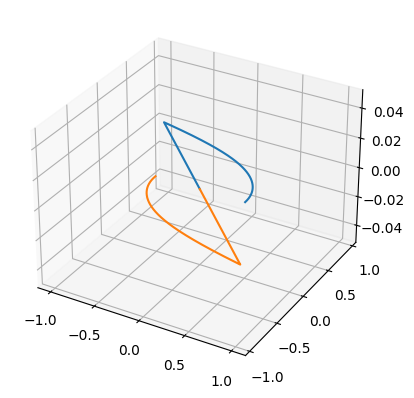

In [8]:
# für die 3D Darstellung der 100 bzw. 1000 Teilchen Trajektorien
import matplotlib.pyplot as plt
ax = plt.figure().add_subplot(projection='3d')


# ax.view_init(20,25,0)

for i in range(0,4):
    ax.plot(course_r[:,i,0],course_r[:,i,1],course_r[:,i,2])
    
    
    
plt.show()

0.0


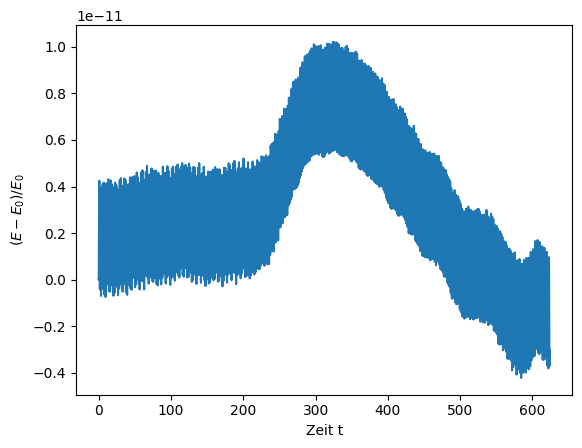

In [25]:
# plottet den zeitlichen Verlauf der Energie
import matplotlib.pyplot as plt
@njit
def eng(pos,vel,k):
    v_sq= np.sum(vel*vel,axis=1)
    T= np.sum(m[:,0]*v_sq)/2
    V= np.zeros(N)
    for n in range(N):
        
        norm = np.sqrt(np.sum((pos-pos[n])**2,axis=1))
        norm[n]=1
        V[n]= np.sum(m[:,0]*m[n,0]*1/norm,axis=0)/2-m[n,0]*m[n,0]/2

    V = np.sum(V)
    return T-V
c_energy= np.zeros(course_r.shape[0])
for i in range(course_r.shape[0]):
    c_energy[i]=eng(course_r[i,:,:],course_v[i,:,:],0)
print(course_t[-1])
fig, ax = plt.subplots(1,1)
ax.plot(course_t,(c_energy-c_energy[0])/c_energy[0])
ax.set_xlabel("Zeit t")
ax.set_ylabel(r"$(E-E_0)/E_0$")
plt.show()

In [48]:
# speichert die Trajektorien
with open("1000b_velo_verlet2.txt","w") as file:
    for i in range(steps//block_size):
        file.write("{:.6e}\t".format(course_t[i]))
        for j in range(N):
            for l in range(3):
                file.write("{:.6e}\t".format(course_r[i,j,l]))
        for j in range(N):
            for l in range(3):
                file.write("{:.6e}\t".format(course_v[i,j,l]))
        file.write("\n")
        
    

#### Hier beginnt die Auswertung der 2 Teilchen Trajektorien

In [35]:
# j, runge-lenz und große Halbachse werden berechnet
c_j = np.zeros((steps//block_size+1,3))
c_rulenz = np.zeros((steps//block_size+1,3))
c_a_bha = np.zeros((steps//block_size+1))
c_rel_r = np.zeros((steps//block_size+1,3))
c_rel_v =np.zeros((steps//block_size+1,3))
for i in range(steps//block_size+1):
    c_j[i,:], c_rel_r[i,:], c_rel_v[i,:] = j_vec(course_r[i,:],course_v[i,:])
    c_rulenz[i,:] = runge_lenz(c_j[i,:],c_rel_r[i,:], c_rel_v[i,:])
    c_a_bha[i] = a_gha(c_j[i,:],c_rulenz[i,:])

In [62]:
with open("2b_iterated_hermite2.txt","w") as file:
    file.write("course_t\tcourse_r[0,x]\tcourse_r[0,y]\tcourse_r[0,z]\tcourse_r[1,x]\tcourse_r[1,y]\tcourse_r[1,z]\tcourse_v[0,x]\tcourse_v[0,y]\tcourse_v[0,z]\tcourse_v[1,x]\tcourse_v[1,y]\tcourse_v[1,z]\tc_energy\tc_totm[x]\tc_totm[y]\tc_totm[z]\tc_tot_angm[x]\tc_tot_angm[y]\tc_tot_angm[z]\tc_j[x]\tc_j[y]\tc_j[z]\tc_rulenz[x]\tc_rulenz[y]\tc_rulenz[z]\tc_a_bha\n")
    for i in range(steps//block_size):
        file.write("{:.6e}\t".format(course_t[i]))
        for j in range(N):
            for l in range(3):
                file.write("{:.6e}\t".format(course_r[i,j,l]))
        for j in range(N):
            for l in range(3):
                file.write("{:.6e}\t".format(course_v[i,j,l]))
        file.write("{:.6e}\t".format(c_energy[i]))
        for j in range(3):
            file.write("{:.6e}\t".format(c_j[i,j]))
        for j in range(3):
            file.write("{:.6e}\t".format(c_rulenz[i,j]))
        file.write("{:.6e}\n".format(c_a_bha[i]))
    


In [ ]:
# Daten könne geladen werden
import pandas as pd
data = pd.read_csv("2b_hermite.txt",sep='\t')
print(data.head())

course_r0 = data[["course_r[0,x]","course_r[0,y]","course_r[0,z]"]].to_numpy()
course_r1 = data[["course_r[1,x]","course_r[1,y]","course_r[1,z]"]].to_numpy()
course_v0 = data[["course_v[0,x]","course_v[0,y]","course_v[0,z]"]].to_numpy()
course_v1 = data[["course_v[1,x]","course_v[1,y]","course_v[1,z]"]].to_numpy()
course_r = np.zeros((course_r1.shape[0],2,3))
course_v = np.zeros((course_r1.shape[0],2,3))
course_r[:,0,:] = course_r0
course_r[:,1,:] = course_r1
course_v[:,0,:] = course_v0
course_v[:,1,:] = course_v1
c_energy= np.zeros(course_r.shape[0])
course_t = data["course_t"].to_numpy()
for i in range(course_r.shape[0]):
    c_energy[i]=eng(course_r[i,:,:],course_v[i,:,:],0)


3.096264637927272


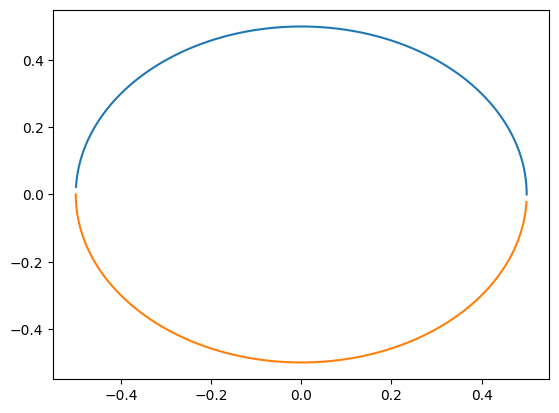

0.5
0.4999977308289387


In [25]:
# 2 body trajektorie wird gezeichnet
print(course_t[-2])

fig, ax = plt.subplots(1,1)
ax.plot(course_r[:-1,0,0],course_r[:-1,0,1])
ax.plot(course_r[:-1,1,0],course_r[:-1,1,1])
plt.show()
print(max(course_r[:,0,0]))
print(max(course_r[:,0,1]))

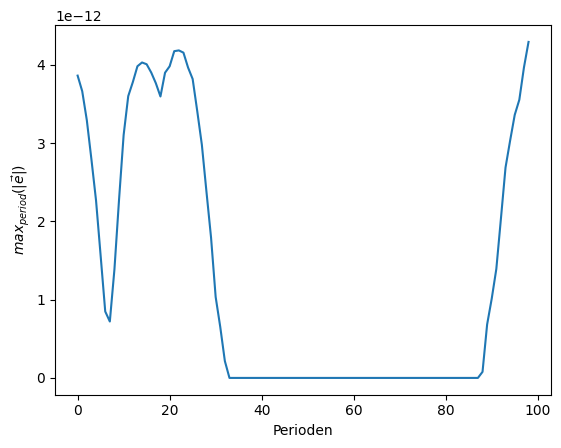

In [28]:
# Da der runge-lenz Vektor immer irgendwie eine Perodische Form hat, werden die Maxima über eine Periode bestimmt und im zeitlichen Verlauf geplottet.
max_e = np.zeros(99)
for i in range(100-1):
    max_e[i] = np.max(c_rulenz[int(steps//block_size/100)*i:int(steps//block_size/100)*(i+1)])
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(99),max_e)
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$max_{period}(|\vec{e}|)$")
plt.show()

In [49]:
c_energy= np.zeros(course_r.shape[0])
for i in range(course_r.shape[0]):
    c_energy[i]=eng(course_r[i,:,:],course_v[i,:,:],0)

C:\Users\Win10 Pro x64\AppData\Local\Temp\ipykernel_13612\2764892289.py:9: RuntimeWarning: divide by zero encountered in log
  ax.plot(course_t[:20*period]/2/np.pi,np.log((e_abs-e_abs[5])/e_abs[5])[:20*period])
C:\Users\Win10 Pro x64\AppData\Local\Temp\ipykernel_13612\2764892289.py:9: RuntimeWarning: invalid value encountered in log
  ax.plot(course_t[:20*period]/2/np.pi,np.log((e_abs-e_abs[5])/e_abs[5])[:20*period])


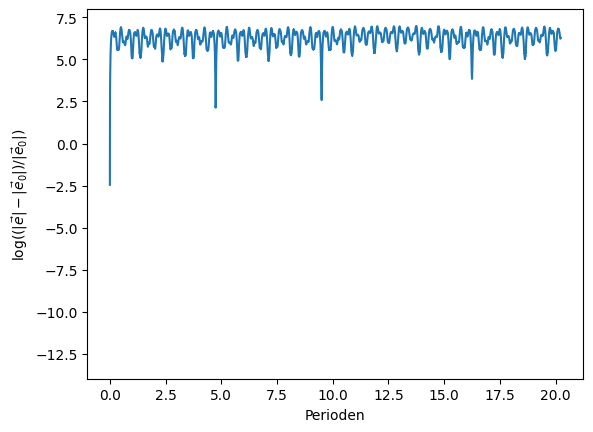

C:\Users\Win10 Pro x64\AppData\Local\Temp\ipykernel_13612\2764892289.py:16: RuntimeWarning: divide by zero encountered in log
  ax.plot(course_t/2/np.pi,np.log(-(j_abs-j_abs[0])/j_abs[0]))
C:\Users\Win10 Pro x64\AppData\Local\Temp\ipykernel_13612\2764892289.py:16: RuntimeWarning: invalid value encountered in log
  ax.plot(course_t/2/np.pi,np.log(-(j_abs-j_abs[0])/j_abs[0]))


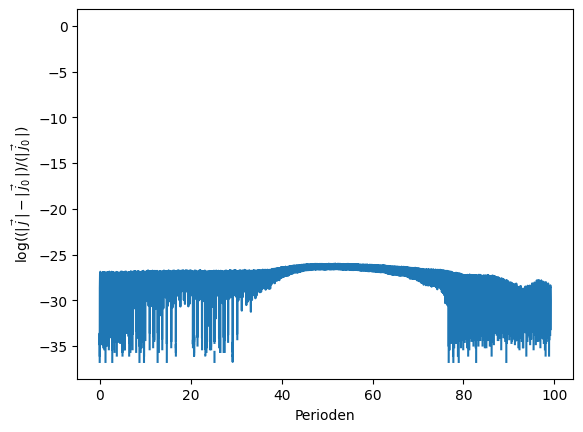

C:\Users\Win10 Pro x64\AppData\Local\Temp\ipykernel_13612\2764892289.py:24: RuntimeWarning: divide by zero encountered in log
  ax.plot(course_t/2/np.pi,np.log((c_energy-c_energy[0])/c_energy[0]))
C:\Users\Win10 Pro x64\AppData\Local\Temp\ipykernel_13612\2764892289.py:24: RuntimeWarning: invalid value encountered in log
  ax.plot(course_t/2/np.pi,np.log((c_energy-c_energy[0])/c_energy[0]))


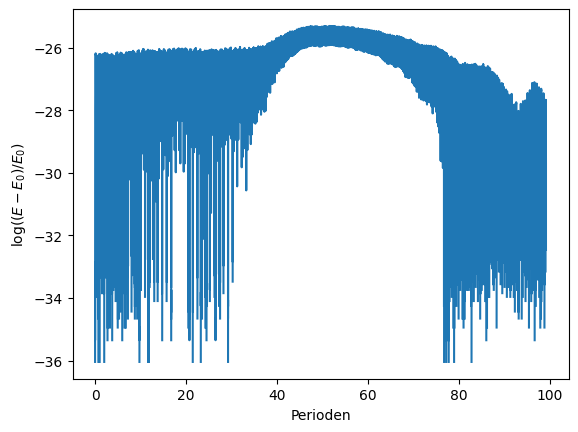

C:\Users\Win10 Pro x64\AppData\Local\Temp\ipykernel_13612\2764892289.py:31: RuntimeWarning: divide by zero encountered in log
  ax.plot(course_t/2/np.pi,np.log(-(c_a_bha-c_a_bha[0])/c_a_bha[0]))
C:\Users\Win10 Pro x64\AppData\Local\Temp\ipykernel_13612\2764892289.py:31: RuntimeWarning: invalid value encountered in log
  ax.plot(course_t/2/np.pi,np.log(-(c_a_bha-c_a_bha[0])/c_a_bha[0]))


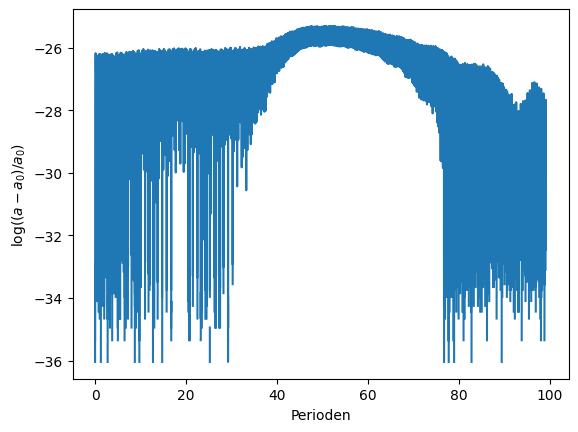

In [30]:
# j, runge-lenz, große Halbachse und E werden logarithmisch in ihere Abweichung vom Ursprungswert geplottet
j_abs = np.sqrt(np.sum(c_j**2,axis=1))
e_abs = np.sqrt(np.sum(c_rulenz**2,axis=1))
fig, ax = plt.subplots(1,1)
save = "yes"
it_name = "hermite"
period = int(steps//block_size/100)
# ax.plot(course_t,np.sqrt(np.sum(c_j**2,axis=1)))
ax.plot(course_t[:20*period]/2/np.pi,np.log((e_abs-e_abs[5])/e_abs[5])[:20*period])
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$\log((|\vec{e}|-|\vec{e}_0|)/|\vec{e}_0|)$")
if save=="yes":
    plt.savefig(it_name+"_log_rulenz_20p.png")
plt.show()
fig, ax = plt.subplots(1,1)
ax.plot(course_t/2/np.pi,np.log(-(j_abs-j_abs[0])/j_abs[0]))
# ax.plot(course_t[:100000],np.sqrt(np.sum(c_rulenz**2,axis=1))[:100000])
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$\log((|\,\vec{j}\,|-|\,\vec{j}_0\,|)/(|\,\vec{j}_0\,|)$")
if save=="yes":
    plt.savefig(it_name+"_log_j.png")
plt.show()
fig, ax = plt.subplots(1,1)
ax.plot(course_t/2/np.pi,np.log((c_energy-c_energy[0])/c_energy[0]))
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$\log((E-E_0)/E_0)$")
if save=="yes":
    plt.savefig(it_name+"_log_E.png")
plt.show()
fig, ax = plt.subplots(1,1)
ax.plot(course_t/2/np.pi,np.log(-(c_a_bha-c_a_bha[0])/c_a_bha[0]))
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$\log((a-a_0)/a_0)$")
if save=="yes":
    plt.savefig(it_name+"_log_a.png")
plt.show()


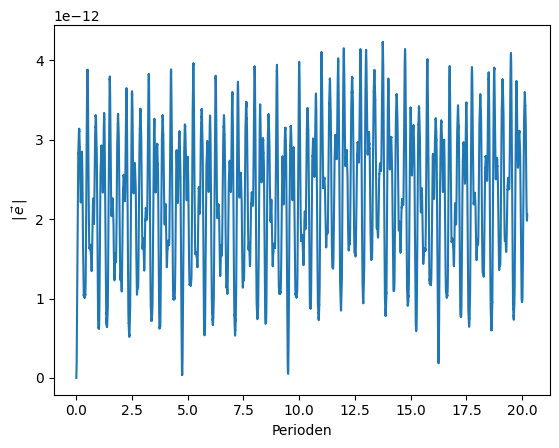

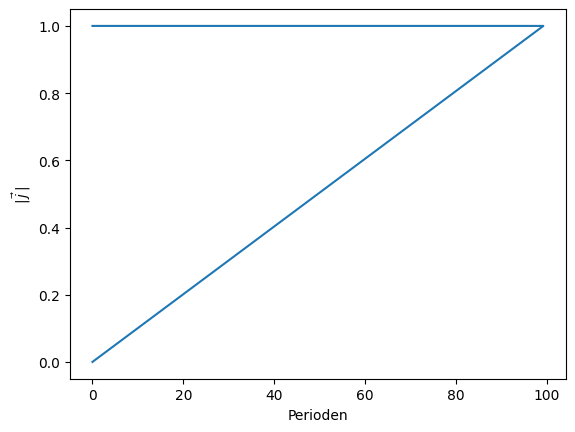

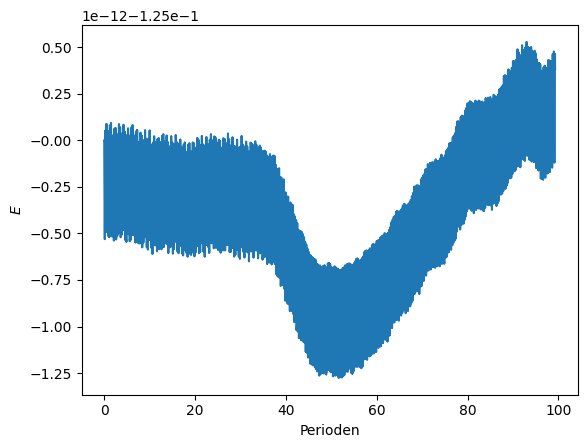

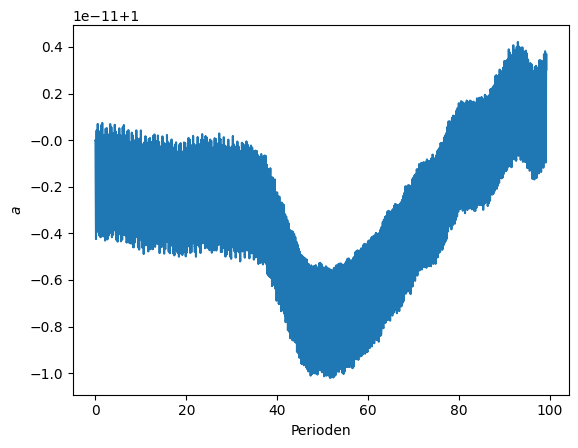

In [32]:
# j, runge-lenz, große Halbachse und E werden linear in ihere Abweichung vom Ursprungswert geplottet
fig, ax = plt.subplots(1,1)
period = int(steps//block_size/100)
save = "yes"
# ax.plot(course_t,np.sqrt(np.sum(c_j**2,axis=1)))
ax.plot(course_t[:20*period]/2/np.pi,e_abs[:20*period])
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$|\,\vec{e}\,|$")
if save=="yes":
    plt.savefig(it_name+"_rulenz_20p.png")
plt.show()
fig, ax = plt.subplots(1,1)
ax.plot(course_t/2/np.pi,j_abs)
# ax.plot(course_t[:100000],np.sqrt(np.sum(c_rulenz**2,axis=1))[:100000])
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$|\,\vec{j}\,|$")
if save=="yes":
    plt.savefig(it_name+"_j.png")
plt.show()
fig, ax = plt.subplots(1,1)
ax.plot(course_t/2/np.pi,c_energy)
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$E$")
if save=="yes":
    plt.savefig(it_name+"_E.png")
plt.show()
fig, ax = plt.subplots(1,1)
ax.plot(course_t/2/np.pi,c_a_bha)
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$a$")
if save=="yes":
    plt.savefig(it_name+"_a.png")
plt.show()